# <a id='toc1_'></a>[Project Intro](#toc0_)

## <a id='toc1_1_'></a>[Goal](#toc0_)

We have been hired by a wine producer's association in Portugal. They have been growing wine for many years, but have been seeing declining sales in major markets outside of Portugal. They'd like for us to use their dataset from the last few years to better understand what these markets deems a good wine. We'd also like to better understand the relationship between alcohol content and other features that contribute to a wine's overall taste. 

## <a id='toc1_2_'></a>[Project Plan](#toc0_)

This wine dataset consists of 1600 wines that have been rated based on their perceived quality. For each of them, we have datapoints on their traits such as pH, sulfates, sulfur dioxide quantities. We will proceed to model alcohol by volume on all relevant predictors using both OLS and WLS models, following by Logistic Regression of quality on the other predictors before talking through correct model interpretations and key takeaways for the wine producers association.


**Table of contents**<a id='toc0_'></a>    
- [Project Intro](#toc1_)    
  - [Goal](#toc1_1_)    
  - [Project Plan](#toc1_2_)    
- [Initial Checks](#toc2_)    
      - [Duplicate values](#toc2_1_1_1_)    
      - [Null values](#toc2_1_1_2_)    
    - [Checking variable domains](#toc2_1_2_)    
      - [Feature descriptions](#toc2_1_2_1_)    
        - [pH values](#toc2_1_2_1_1_)    
  - [Correlations](#toc2_2_)    
- [Modeling](#toc3_)    
  - [Backward Elimination](#toc3_1_)    
  - [Model validation](#toc3_2_)    
    - [Expected value of residuals](#toc3_2_1_)    
    - [Heteroscedasticity : Breusch-Pagan Test](#toc3_2_2_)    
  - [Outliers](#toc3_3_)    
    - [Leverage](#toc3_3_1_)    
    - [Normality of the residuals](#toc3_3_2_)    
  - [Multicollinearity](#toc3_4_)    
  - [Linearity](#toc3_5_)    
  - [Diagnostic Summary](#toc3_6_)    
  - [Eliminating outliers](#toc3_7_)    
      - [Outliers by Cook's distance](#toc3_7_1_1_)    
      - [Outliers by leverage](#toc3_7_1_2_)    
  - [Model Improvements](#toc3_8_)    
    - [Option 1](#toc3_8_1_)    
  - [Option 1 model performance](#toc3_9_)    
    - [Option 2](#toc3_9_1_)    
- [Weighted Least Squares](#toc4_)    
  - [WLS model creation](#toc4_1_)    
  - [WLS validation](#toc4_2_)    
    - [WLS model testing](#toc4_2_1_)    
  - [Logistic Regression](#toc4_3_)    
- [Model interpretations](#toc5_)    
  - [Weighted Least Squares](#toc5_1_)    
  - [Logistic Regression](#toc5_2_)    
- [Conclusions](#toc6_)    
- [Ideas for further research](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
from random import randint
from scipy.stats import zscore
from skimpy import skim
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import WLS, OLS
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix,
)
from sklearn.feature_selection import RFE
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import linear_rainbow
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import pylab as py
import scipy.stats as stats

In [3]:
# Import all helper functions from a separate module
from wine_functions import (
    duplicate_checker,
    null_value_printer,
    single_mean_test,
    dataset_splitter,
    define_x_and_y,
    find_max_p_value,
    run_OLS,
    calculate_expected_value,
    plot_residuals,
    backward_elimination,
    scaled_backward_elimination,
    breusch_pagan_test,
    plot_cooks_distance,
    create_outlier_dataframe,
    plot_influence_studentized,
    jarque_bera_test,
    calculate_VIF,
    harvey_collier_test,
    rainbow_test,
    qq_plot_residuals,
    calculate_residuals,
    plot_influence,
    single_mean_test,
    compare_regressions,
    scale_dataframe,
    back_elimination,
    RFE_performance,
    RFE_performance_training,
)

In [4]:
# Set some printing style parameters
palette = sns.color_palette("bright")

# Adjust pandas display setting
pd.set_option("display.max_colwidth", None)

# Set default figure size
sns.set(rc={"figure.figsize": (16, 8)})

%matplotlib inline

#Set significance level for all hypothesis tests
significance_level = 0.05

In [5]:
# Import wine dataset from csv
wine_df = pd.read_csv("winequality-red.csv")

# Change column names to use underscores instead of spaces
wine_df.columns = [
    "fixed_acidity",
    "volatile_acidity",
    "citric_acid",
    "residual_sugar",
    "chlorides",
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
    "quality",
]
wine_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# <a id='toc2_'></a>[Initial Checks](#toc0_)

#### <a id='toc2_1_1_1_'></a>[Duplicate values](#toc0_)

In [6]:
wine_df[wine_df.duplicated() == True]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1563,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1564,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1567,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1581,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


We have 240 duplicate rows, which might not present new information. As a non-expert on wine, I believe there is a possibility that two different wines could score exactly the same on all dimensions if they were produced from the same grape harvest at the same vineyard during the same year, so it would be unwise to drop these 240 rows without further information, esp. since we only have 1600 datapoints to use in our models. Let's note that we might have duplicates, but keep them nonetheless.

#### <a id='toc2_1_1_2_'></a>[Null values](#toc0_)

In [7]:
null_value_printer(wine_df)

Zero null values


We have no null values in this dataset, but we can check the columns for different encoding of null values. Because this dataframe was read in from a csv, null values could have been encoded as zeroes or -1 values for example. We can check for anomalies like this while we investigate the domains the columns.

### <a id='toc2_1_2_'></a>[Checking variable domains](#toc0_)
#### <a id='toc2_1_2_1_'></a>[Feature descriptions](#toc0_)
According to the dataset we have the following description of the features within this dataset:


- **Fixed acidity (g/L)**: This measures the non-volatile acidity of the wine, primarily contributed by tartaric acid, a natural component of grape juice. Higher fixed acidity indicates a more acidic wine, which can influence the wine's flavor and aging potential.

- **Volatile acidity (g/L)**: This measures the concentration of volatile acids, primarily acetic acid, in the wine. Excessive volatile acidity, often caused by bacterial spoilage, can produce an unpleasant vinegar-like aroma and taste.

- **Citric acid (g/L)**: This measures the amount of citric acid, another natural component of grape juice, in the wine. Citric acid contributes to the wine's tartness and freshness, influencing overall flavor perception.

- **Residual sugar (g/L)**: This measures the unfermented sugar remaining in the wine after fermentation. The level of residual sugar plays a crucial role in determining the sweetness of the wine, ranging from dry to sweet styles.

- **Chlorides (g/L)**:This measures the concentration of chloride salts, primarily sodium chloride, in the wine. Chloride levels can influence the wine's salinity and balance, potentially affecting its overall taste perception.

- **Free sulfur dioxide (mg/L)**: This measures the concentration of sulfur dioxide molecules that are unbound to other compounds in the wine. Sulfur dioxide is a common preservative used to prevent wine spoilage and oxidation, but excessive levels can impart a pungent, sulfurous odor and taste.

- **Total sulfur dioxide (mg/L)**: This measures the total amount of sulfur dioxide, including both free and bound forms, present in the wine. Total sulfur dioxide content is important for maintaining wine quality and preventing spoilage, but excessive levels can negatively impact the wine's sensory characteristics.

- **Density (g/cm³)**: This measures the mass per unit volume of the wine. Wine density is influenced by factors such as alcohol content and sugar content. Higher density generally indicates a higher alcohol content or a sweeter wine.

- **Sulphates (g/L)**: This measures the concentration of sulfate salts, primarily potassium sulfate, in the wine. Sulfates are naturally present in grapes and can also be added during winemaking processes. Excessive sulfate levels may contribute to a bitter or metallic taste in the wine.

- **Alcohol (volume percentage)**: This measures the percentage of alcohol by volume in the wine. Alcohol is a primary factor influencing the wine's flavor, body, and complexity. Higher alcohol levels generally result in fuller-bodied wines with stronger aromas and flavors.

**Citation:** https://archive.ics.uci.edu/dataset/186/wine+quality

##### <a id='toc2_1_2_1_1_'></a>[pH values](#toc0_)
With the exception of pH, all variables are densities in grams per liter, grams per cubic centimeter, or milligrams per liter. Let's skim the dataset to check that all values are greater than zero, and that pH is within a normal range.

In [8]:
skim(wine_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1599   │ │ float64     │ 11    │                                                          │
│ │ Number of columns │ 12     │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA  ┃ NA %  ┃ mean   ┃ sd      ┃ p0     ┃ p25   ┃ p50    ┃ p75   ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ fixed_acidity           │   0 │     0 │    8.3 │     1.7 │    4.6 │   7.1 │    7.9 │   9.2 │   16 │  ▁▇▃▂  │  │
│ │ volatile_acidity        │   0 │     0 │   0.53 │    0.18 │   0.12 │  0.39 │   0.52 │  0.64 │  1.6 │  ▃▇▅▁  │  │
│ │ citric_acid             │   0 │     0 │   0.27 │    0.19 │      0 │  0.09 │   0.26 │  0.42 │    1 │  ▇▇▆▃  │  │
│ │ residual_sugar          │   0 │     0 │    2.5 │     1.4 │    0.9 │   1.9 │    2.2 │   2.6 │   16 │   ▇▁   │  │
│ │ chlorides               │   0 │     0 │  0.087 │   0.047 │  0.012 │  0.07 │  0.079 │  0.09 │ 0.61 │   ▇▁   │  │
│ │ free_sulfur_dioxide     │   0 │     0 │     16 │      10 │      1 │     7 │     14 │    21 │   72 │  ▇▆▃▁  │  │
│ │ total_sulfur_dioxide    │   0 │     0 │     46 │      33 │      6 │    22 │     38 │    62 │  290 │  ▇▃▁   │  │
│ │ density                 │   0 │     0 │      1 │  0.0019 │   0.99 │     1 │      1 │     1 │    1 │  ▂▇▇▂  │  │
│ │ pH                      │   0 │     0 │    3.3 │    0.15 │    2.7 │   3.2 │    3.3 │   3.4 │    4 │  ▂▇▅▁  │  │
│ │ sulphates               │   0 │     0 │   0.66 │    0.17 │   0.33 │  0.55 │   0.62 │  0.73 │    2 │  ▇▇▁   │  │
│ │ alcohol                 │   0 │     0 │     10 │     1.1 │    8.4 │   9.5 │     10 │    11 │   15 │ ▃▇▅▂▁  │  │
│ │ quality                 │   0 │     0 │    5.6 │    0.81 │      3 │     5 │      6 │     6 │    8 │  ▁▇▇▂  │  │
│ └─────────────────────────┴─────┴───────┴────────┴─────────┴────────┴───────┴────────┴───────┴──────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Though skimpy has a histogram column for each variable, let's plot them so we have a better sense of how balanced our dataset is in greater detail.

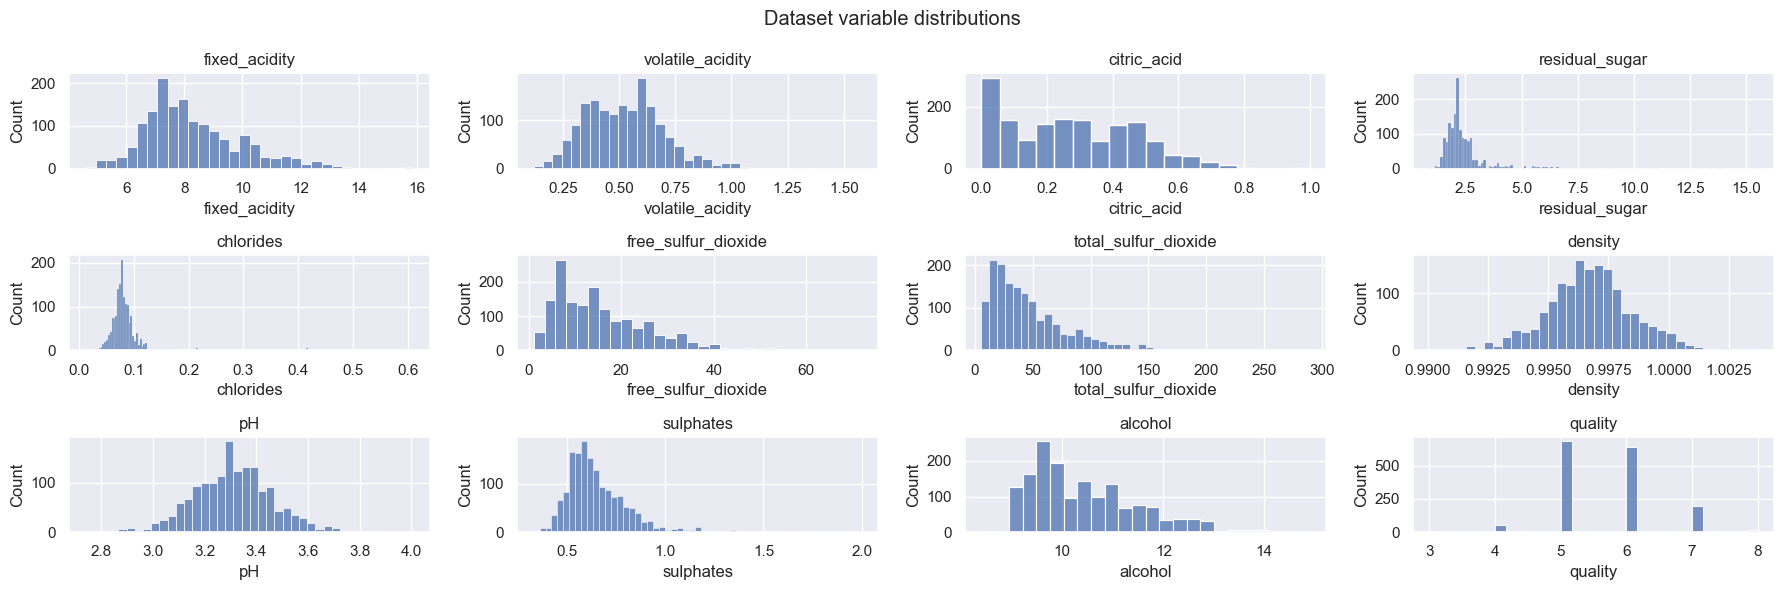

In [9]:
# Create subplots outside the loop
fig, axes = plt.subplots(3, 4, figsize=(18, 6))
plt.suptitle("Dataset variable distributions")

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each column and subplot
for i, column in enumerate(wine_df.columns):
    sns.histplot(data=wine_df, x=column, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

All values are non-negative, and have densities within the normal range. pH is greater than 0 and less than or equal to 4.01 which makes sense given that wines are acidic. With the exception of density, pH, and quality, the features here aren't centered, suggesting that we have outliers in the dataset. We'll have to check this out later, but now that we've checked for null values, duplicates, and reasonable domains for all variables within our dataframe, we can continue by checking correlations.

## <a id='toc2_2_'></a>[Correlations](#toc0_)

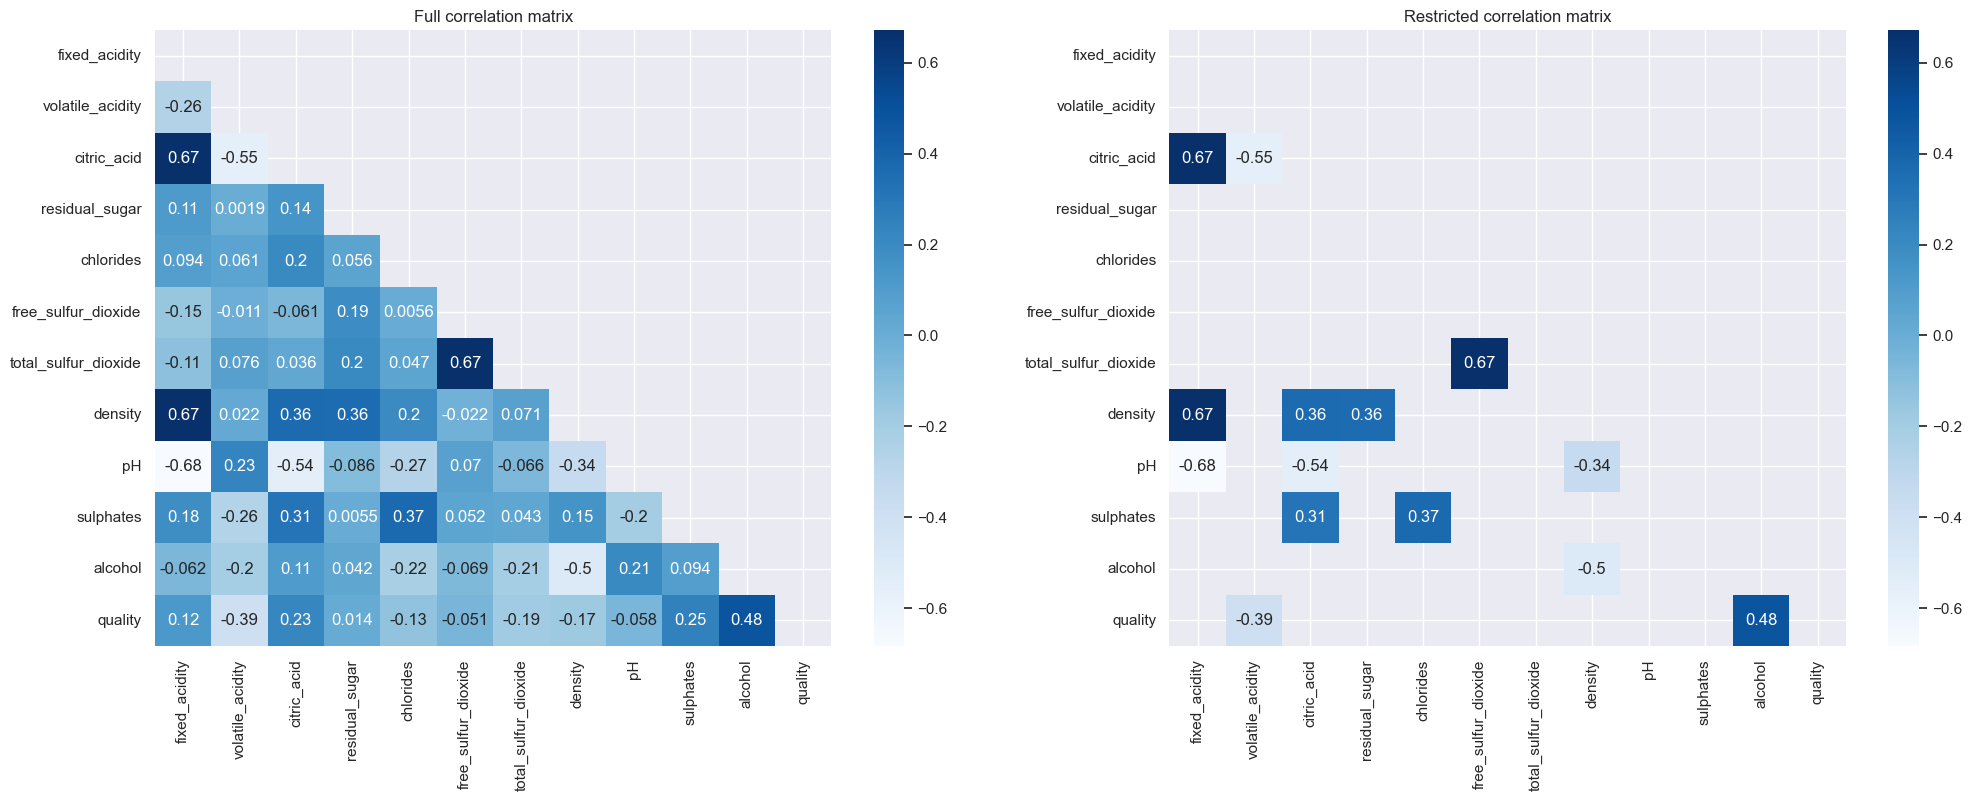

In [10]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Defined correlation matrix for our model variables
corr = wine_df.corr()

# Set correlation matrix filter
matrix = np.triu(corr)
sns.set_style("darkgrid")

# Plot
sns.heatmap(corr, annot=True, mask=matrix, cmap="Blues", ax=axes[0])
axes[0].set_title("Full correlation matrix")


# Apply absolute value filter and reprint heatmap
correlations = corr[np.abs(corr) > 0.3]
sns.heatmap(correlations, annot=True, mask=matrix, cmap="Blues", ax=axes[1])
axes[1].set_title("Restricted correlation matrix")
plt.show()

The graph on the right filters out all variable combinations that don't meet the threshold for strong positive or strong negative correlations. Some of these are obvious relationships in the features, e.g. total_sulfur_dioxide being correlated with free_sulfur_dioxide, but there are less obvious relationships like pH and density being inversely correlated. We'll have to keep in mind during later modeling that our features are not entirely independent of each other, given that chemical processes in winemaking happen within in a controlled, closed system. 

# <a id='toc3_'></a>[Modeling](#toc0_)
## <a id='toc3_1_'></a>[Backward Elimination](#toc0_)
In this section we're going to create two different models, one a linear regression model that regresses wine quality against a set of features, and the other a classification model that groups the wines as good or bad based on a set of features. 
We'll use the backward elimination method for building this model. Algorithmically speaking, we'll do the following to achieve this:

<u>**Backward-Elimination**</u>
1. Select a significance level
2. Fit the model with all features
3. Identify which feature has highest P-value
4. Remove the feature with highest P-value
5. Fit the model again (Return to step 2) and stop if p-value of all features is more than significance level

Before we do any multivariate modeling, we should scale the data given that all of the data has different units, and pH is on a logarithmic scale. We'll be better able to compare unit changes across variables if the X-matrix is scaled first 

In [11]:
# Define x and y dataframes and scale DFs
X, Y = define_x_and_y(wine_df,"alcohol", scale_X=True)

# Initialize back_elimination class
model_1 = back_elimination()

# Run backward elimination algorithm
ols = model_1.backward_elimination(X, Y)
print(ols.summary())
print(f"\nRegression ran {model_1.regression_counter} times.")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     280.2
Date:                Mon, 06 May 2024   Prob (F-statistic):          2.58e-278
Time:                        08:11:54   Log-Likelihood:                -981.71
No. Observations:                1119   AIC:                             1983.
Df Residuals:                    1109   BIC:                             2034.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.4243 

Our backward elimination process ran 2 times, and we ended on a model with 8 variables. Let's validate this model against OLS assumptions.

## <a id='toc3_2_'></a>[Model validation](#toc0_)

In this section we'll check for the following assumptions of the OLS model: 
1. Expected value of residuals equal to zero
2. Homoskedasticity
3. Error terms are normally distributed 
4. There is no multicollinearity (at least, there is no perfect collinearity) 
5. Linearity


Let's save important details about our model as variables before getting any further.

In [12]:
# number of predictors as variables
k = len(ols.params.index[1:])

# number of observations
n = int(ols.nobs)

# calculate residuals
residuals = ols.resid

Let's plot residuals to get an initial visual.

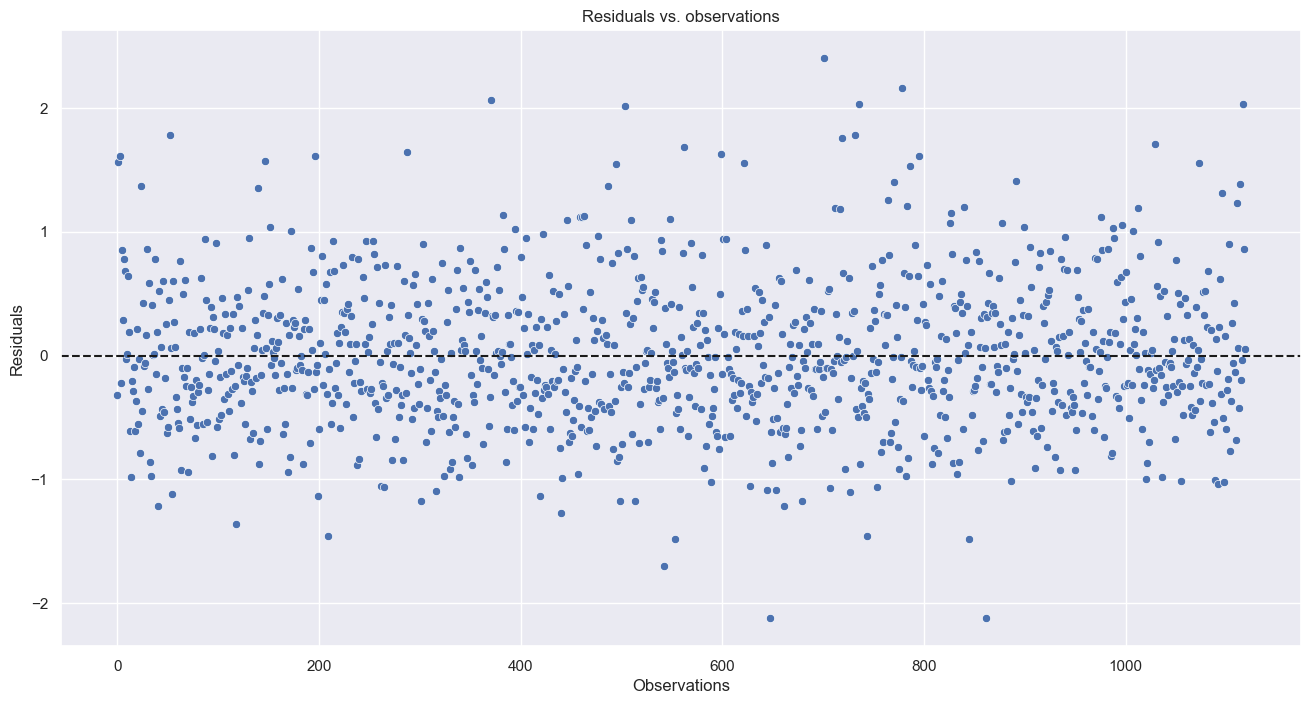

In [13]:
plot_residuals(residuals)

Our residuals generally fit within a tight band, but there are outliers both above and below the denser "data cloud" here.

### <a id='toc3_2_1_'></a>[Expected value of residuals](#toc0_)
If our regression model is properly defined, then the expected value of our residuals should be 0. Let's check if that's true. 

In [14]:
calculate_expected_value(residuals)

-6.913279627582258e-16

Our residual expected value is infintesimally close to zero, so the model has passed this OLS assumption. Let's check for constant variance next. 



### <a id='toc3_2_2_'></a>[Heteroscedasticity : Breusch-Pagan Test](#toc0_)
The Breusch–Pagan test tests whether the variance of the errors from a regression is dependent on the values of the independent variables. In that case, heteroscedasticity is present. It is a chi-squared test: the test statistic is distributed nχ2 with k degrees of freedom. If the test statistic has a p-value below an appropriate threshold (e.g. p < 0.05) then the null hypothesis of homoskedasticity is rejected and heteroscedasticity assumed.

If the Breusch–Pagan test shows that there is conditional heteroscedasticity, one could either use weighted least squares (if the source of heteroscedasticity is known) or use heteroscedasticity-consistent standard errors.We'll use Breusch-Pagan because of its simplicity.

${H_0}$: The variance of our regression model's errors is constant. 
<br>${H_1}$: The variance of our regression model's errors is dependent on the values of the independent variables.

In [15]:
stats_list = ["Lagrange multiplier statistic", "p-value", "F-value", "F-test p-value"]
test = het_breuschpagan(ols.resid, ols.model.exog)
print(
    pd.DataFrame(data={"statistic": stats_list, "value": test}).sort_values(
        "value", ascending=True
    )
)

# Reject the null hypothesis if needed
if test[1] < significance_level:
    print("\nReject the null hypothesis, heteroscedastic errors.")
else:
    print("Fail to reject the null hypothesis, homoscedastic errors.")

                       statistic         value
3                 F-test p-value  1.302015e-21
1                        p-value  1.802064e-20
2                        F-value  1.404194e+01
0  Lagrange multiplier statistic  1.144722e+02

Reject the null hypothesis, heteroscedastic errors.


Our p-value is much smaller than our significance level, which means we have a heteroskedastic model. This detail isn't a deal breaker, but it means that our model will have less predictive power over certain ranges of x in our domains. Since we have proof of heteroscedasticity, we should also check for outliers. This will help us identify which observations have an outsized effect on our regression model.


## <a id='toc3_3_'></a>[Outliers](#toc0_)

### <a id='toc3_3_1_'></a>[Leverage](#toc0_)
Cook’s distance is a measure of the effect of deleting an observation on the estimated coefficients. It takes into account both the leverage and the residual of the observation. High Cook’s distance indicates that the observation has a large effect on the estimated coefficients when it’s deleted. We'll use it to dive into our training set in order to identify where our data sways our regresssion being more "centered." 

The higher Cook's distance is for a given observation, the more likely that observation is to be influential. The Cook’s distance is useful for identifying influential data points as it measure the change in regression estimate if the observation is deleted.

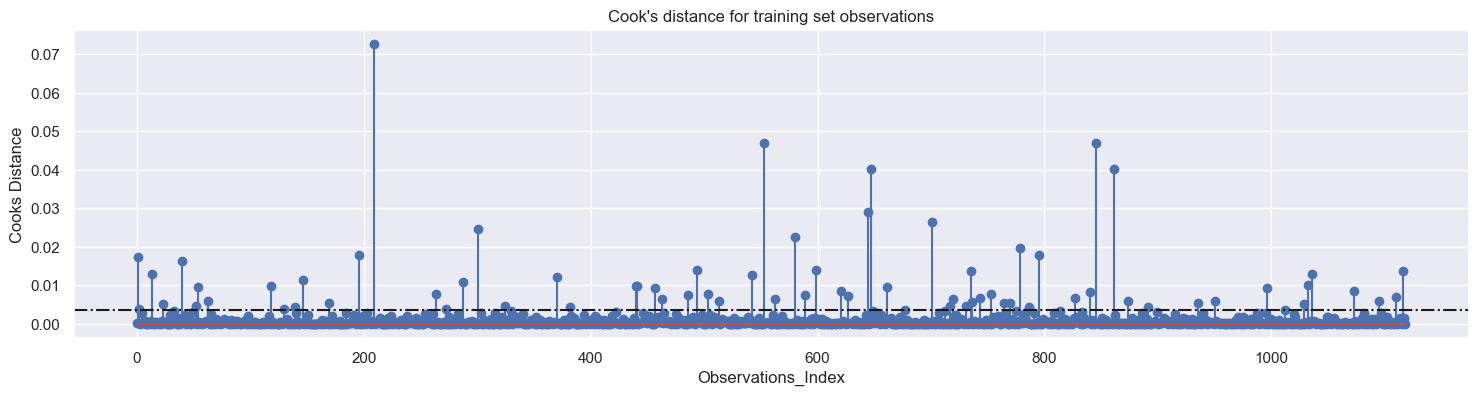

In [16]:
# Calculate Cook's distance for our OLS model
influence = ols.get_influence()
(cooks, _) = influence.cooks_distance

# Let's also create a dataframe of outliers with their influence values
outliers_df = pd.DataFrame(data={"residual": residuals, "cooks_distance": cooks})

# Define cook's distance rejection threshold
cooks_threshold = 4 / (n - k - 1)

# stemplot for cooks distance
plt.subplots(figsize=(18, 4))
plt.xlabel("Observations_Index")
plt.ylabel("Cooks Distance")

plt.stem(np.arange(len(model_1.x_train)), cooks)

plt.axhline(y=cooks_threshold, color="k", linestyle="-.")
plt.title("Cook's distance for training set observations")
plt.show()

The black dotted line denotes our rejection threshold based on our dataset which is $\frac {4}{n-k-1}$. This is a more conservative threshold than simply using $\frac{4}{n}$ because it controls for the number of predictors in our model. By this metric, a large percentage of our dataset could be considered outliers. Let's see how much our training set would fall into this region before we look at studentized residuals.


In [17]:
# Isolate the observations
cooks_outliers = outliers_df[outliers_df.cooks_distance >= cooks_threshold]

print(
    f"# of Cook's distance outliers: {len(cooks_outliers)}\nProportion of dataset: {np.round(len(cooks_outliers)/n,3)}"
)

# of Cook's distance outliers: 71
Proportion of dataset: 0.063


According to cook's distance, these 71 observations should be removed from our model to improve it. let's consider another metric, studentized residuals. <br><br>This metric is often considered more useful for identifying residuals to be removed from the model because when trying to identify outliers, one problem that can arise is when there is a potential outlier that influences the regression model to such an extent that the estimated regression function is "pulled" towards the potential outlier, so that it isn't flagged as an outlier using the standardized residual criterion. <br><br>To address this issue, studentized residuals offer an alternative criterion for identifying outliers. The basic idea is to delete the observations one at a time, each time refitting the regression model on the remaining n–1 observations. Then, we compare the observed response values to their fitted values based on the models with the i-th observation deleted. This produces deleted residuals. Standardizing the deleted residuals then produces studentized residuals.


In [18]:
# add studentized residuals to our outliers dataframe
outliers_df["studentized_residuals"] = influence.resid_studentized

# We'd like to consider observations with studentized residual values >|3|. Let's see how many we have
studentized_outliers = outliers_df.studentized_residuals[
    outliers_df.studentized_residuals > 3
]

By this metric, we only have 7 observations that should be considered outliers and should be removed from the model. Let's focus on leverage in this dataset--leverage is part of the studentized residual calculations, but I want to consider it separately since it measures how far an observation is from the average value of the independent variable.<br><br> High leverage observations are those that are far away from the average and have a large effect on the regression line's fitting. With this metric, a general guideline is to consider points with leverage values greater than $\frac{2k}{n}$ as high leverage points, so we'll mark that limit in the graph below, and calculate how many points fall within our high-leverage region.


The training set has 97 high-leverage points.


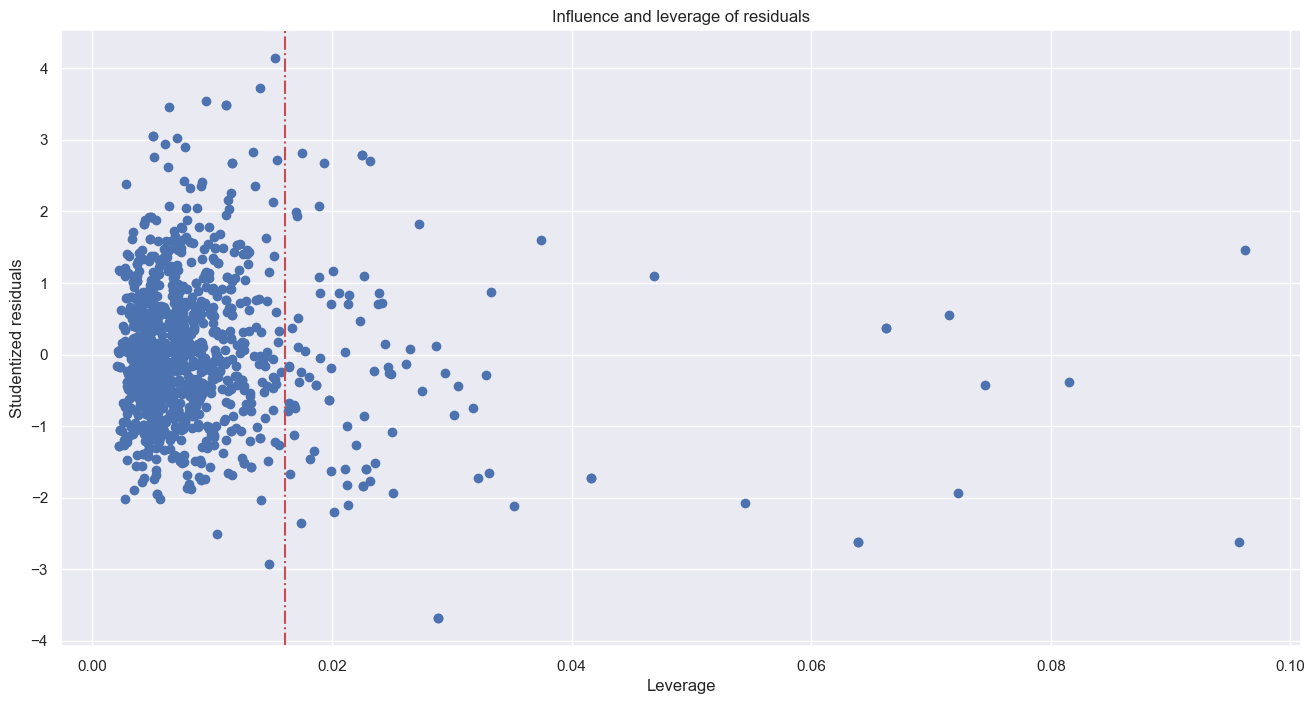

In [19]:
outliers_df["influence"] = influence.influence
outliers_df["leverage"] = influence.hat_matrix_diag

# Create subplots
# fig, axes = plt.subplots(1, 2)
plt.scatter(data=outliers_df, x="leverage", y="studentized_residuals")
plt.xlabel("Leverage")
plt.title("Influence and leverage of residuals")
plt.ylabel("Studentized residuals")


# Calculate high leverage threshold
sr_threshold = 2 * k / n

plt.axvline(x=sr_threshold, color="r", linestyle="-.")
print(
    f"The training set has {len(outliers_df[outliers_df.leverage>sr_threshold])} high-leverage points."
)

Our data roughly forms a densely populated cloud of data below our studentized residuals threshold, with 94 datapoints falling within this region. Now that we have a good view of our outliers, let's examine the shape and underlying distribution of our residuals.

### <a id='toc3_3_2_'></a>[Normality of the residuals](#toc0_)
Let's start with the the Jarque-Bera test for normality of residuals. This goodness-of-fit test assumes that the residuals are from a normally distributed sample, and tests whether the skewness and kurtosis of the sample match those of a normal distribution.

$H_0$ = data comes from a normal distribution<br>
$H_1$ = data does not come from a normal distribution

In [20]:
# Jarque-Bera test for normality
statistics = jarque_bera(residuals, axis=0)

name = ["Jarque-Bera", "p-value", "skewness", "kurtosis"]
pd.DataFrame(data={"statistics": name, "values": statistics})

,statistics,values
0,Jarque-Bera,8.766091e+01
1,p-value,9.218805e-20
2,skewness,4.565199e-01
3,kurtosis,4.022979e+00


Looking at the results here, our skewness and kurtosis are close to zero, meaning that our data follows the shape and symmetry seen in the normal distribution. However we can see that the Jarque-Bera statistic is rather large at 54.91, with an incredibly small p-value. Taken together, these two stats mean that we should reject the null hypothesis that we have residuals coming from a normal distribution.

Let's print the qqplot of residuals to show graphically how far off from normality were are graphically.

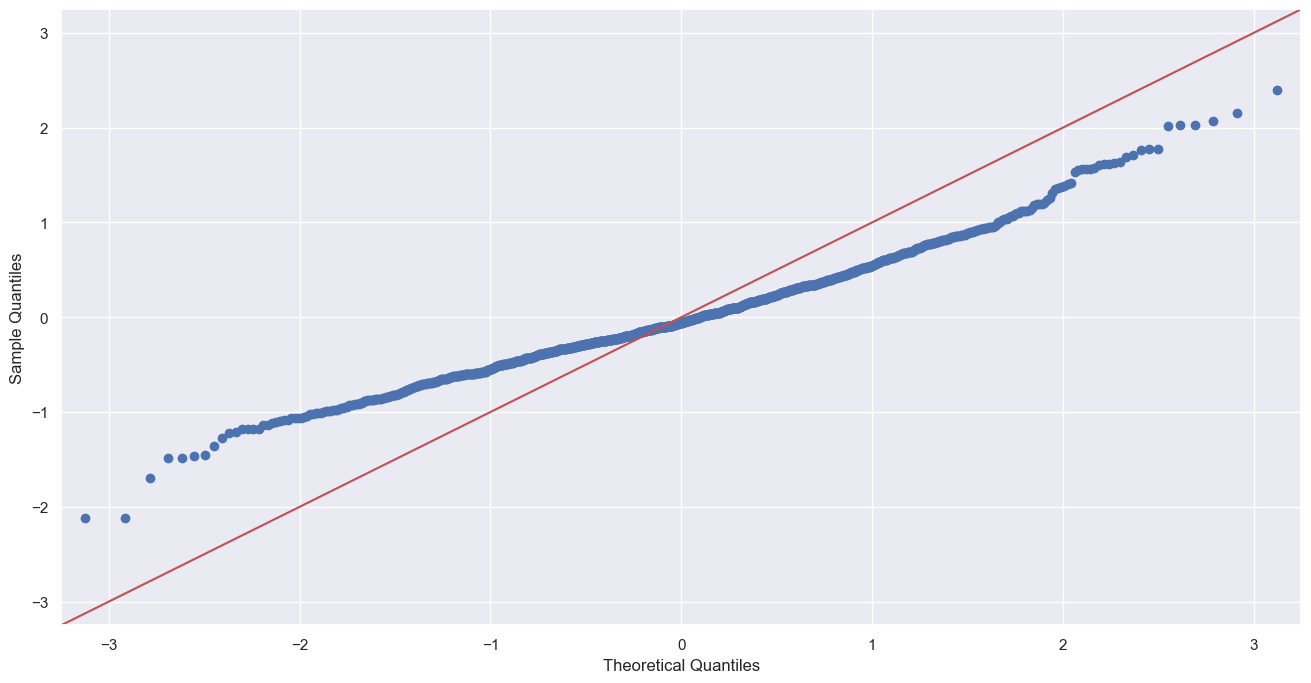

In [21]:
sm.qqplot(residuals, line="45")
py.show()

This residual plot needs improvement, and further corroborates our heteroscedasticity conclusions. Let's keep checking assumptions.

## <a id='toc3_4_'></a>[Multicollinearity](#toc0_)

Checking for multicollinearity is important to understand how precise our coefficients are. Linear regression models assume that predictors are independent of each other, and therefore can be used to measure the effect of a given variable $x_i$ on the dependent variable. We need to know if our predictors are fully independent because we want to be able to trust that our model is working as intended under the hood. <br><br> We'll use VIF, the variance inflation factor to test each feature's multicollinearity with the other features of the model. If VIF is great than 5, then it is highly collinear with other explanatory variables, and the parameter estimates with have large standard errors, compromising the strength of our model.

Variance inflation factor, VIF, for one exogenous variable

The variance inflation factor is a measure for the increase of the variance of the parameter estimates if an additional variable is added to the linear regression. It is a measure for multicollinearity of the X matrix.


In general terms:

- VIF equal to 1 $\rightarrow$ variables are not correlated
- VIF between 1 and 5 $\rightarrow$ variables are moderately correlated 
- VIF greater than 5 $\rightarrow$ variables are highly correlated
<br><br>

The higher the VIF, the higher the possibility that multicollinearity exists, and if VIF is higher than 10, there is significant multicollinearity that needs to be corrected.

In [22]:
# Calculate VIF for each variable in X training set
VIF = []
variables = []
for idx, element in enumerate(model_1.x_train.columns):
    VIF.append(variance_inflation_factor(model_1.x_train, idx))
    variables.append(element)

# Create dataframe, excluding the regression constant since VIF only applies to predictors
VIF_df = pd.DataFrame(data={"variable": variables, "VIF": VIF})

# Drop row for constant
VIF_df = VIF_df[VIF_df["variable"] != "const"].sort_values("VIF", ascending=True)
VIF_df

,variable,VIF
5,total_sulfur_dioxide,1.223936
8,sulphates,1.240111
4,residual_sugar,1.257193
9,quality,1.429073
2,volatile_acidity,1.693894
7,pH,2.221888
3,citric_acid,2.728250
6,density,2.836407
1,fixed_acidity,5.082093


All of our predictors in this model are moderately correlated--let's see which variables in our data are correlated according to the pearson statistic. Fixed acidity has the highest VIF value, so we should keep a close eye on that variable.

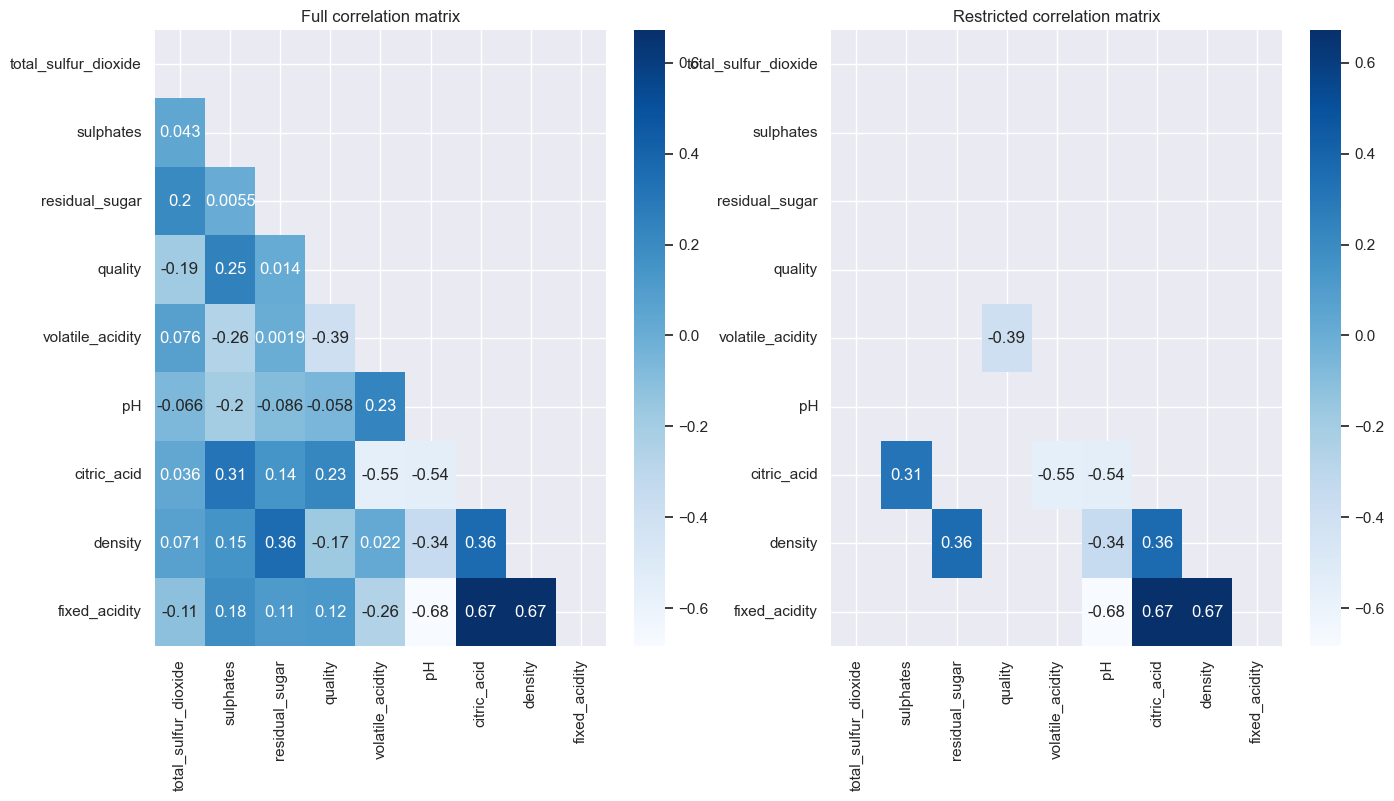

In [23]:
# Create subplots
fig, axes = plt.subplots(1, 2)

# Defined correlation matrix for our model variables
corr = wine_df[VIF_df.variable].corr()

# Set correlation matrix filter
matrix = np.triu(corr)
sns.set_style("darkgrid")

# Plot
sns.heatmap(corr, annot=True, mask=matrix, cmap="Blues", ax=axes[0])
axes[0].set_title("Full correlation matrix")


# Apply absolute value filter and reprint heatmap
correlations = corr[np.abs(corr) > 0.3]
sns.heatmap(correlations, annot=True, mask=matrix, cmap="Blues", ax=axes[1])
axes[1].set_title("Restricted correlation matrix")
plt.show()

The subplot on the right shows only the moderate to high correlations in our model, and the correlations between fixed acidity, density, and citric acid all make sense--pH and fixed acidity must be correlated because pH measures acidity logarithmically for example. These features are potentially duplicative for our analysis, so we could consider methods like PCA to minimize the effects of multicollinearity in the data with linear algebra, but first, let's examine whether or not the assumption that a linear model is the proper specification for our data. 

## <a id='toc3_5_'></a>[Linearity](#toc0_)

We'll use two different tests for linearity here, The Harvey-Collier Test and the Rainbow Test. 

The Harvey-Collier test performs a t-test on the recursive residuals. If the true relationship is not linear but convex or concave the mean of the recursive residuals should differ from 0 significantly. 

The Rainbow test is useful here; the basic idea is that if the true relationship is non-linear, a good linear fit can be achieved on a subsample in the "middle" of the data. The Rainbow test describes whether a model improves when data is removed, under the null hypothesis that the true model is linear. However, if the true model is not linear, then the improvement gained by removing data will be greater than expected. In this test, a flexible regression model (splines, polynomial regression, or non-parametric regression) is fitted to the residuals of the original linear regression model. This flexible model aims to capture any remaining non-linear patterns or curvature in the relationship between the independent variables and the dependent variable that the linear model may have failed to capture. By comparing the fit of the flexible model to that of the linear model, the Rainbow test assesses whether the linear assumption is adequate or if additional complexity is needed to adequately model the relationship. If the flexible model significantly improves the fit compared to the linear model, it suggests that the linear assumption may be violated, and the relationship may be non-linear.


So why use both tests? Though they both test for linearity, The Harvey-Collier test examines the linearity assumption by comparing the residuals from the original regression model with the fitted values obtained from a separate regression of the dependent variable on the independent variable. Meanwhile the Rainbow test tests for linearity by comparing the fitted values obtained from the original regression model for the middle portion of the data with those for the entire dataset. <br><br>Therefore, the Harvey-Collier test assesses linearity based on the distribution of residuals around zero: a significant deviation from this distribution suggests nonlinearity.
The Rainbow test assesses linearity based on the consistency of the relationship between the dependent and independent variables across the range of the data, so a significant difference in fitted values would suggest nonlinearity.

<u>**Harvey-Collier Test**</u><br>
$H_0$ = This regression model is correctly specified as a linear model.<br>
$H_1$ = The relationship between the dependent variable and independent variables is non-linear, suggesting that the regression model is misspecified as being a linear relationship.


In [24]:
skip = len(ols.params)
rr = sms.recursive_olsresiduals(ols, skip=skip, alpha=0.95, order_by=None)

# Conduct t-test on standardized recursive residuals
tval, pval = stats.ttest_1samp(rr[3][skip:], 0)
if pval < significance_level:
    print(
        f"p-value: {np.round(pval,3)}. \nReject the null hypothesis, model is improperly specified as a linear model"
    )
else:
    print(
        f"p-value: {np.round(pval,3)}. \nFail to reject the null hypothesis, model is correctly specified as a linear model."
    )

p-value: 0.829. 
Fail to reject the null hypothesis, model is correctly specified as a linear model.



<u>**Rainbow Test**</u><br>
$H_0$ = This regression model is correctly specified as a linear model.<br>
$H_1$ = The relationship between the dependent variable and independent variables is non-linear, suggesting that the linear regression model is misspecified.

In [25]:
fstat, pvalue = linear_rainbow(ols)

if pvalue < significance_level:
    print(
        f"p-value: {np.round(pvalue,3)}. \nReject the null hypothesis, the model is improperly specified as a linear model"
    )
else:
    print(
        f"p-value: {np.round(pvalue,3)}. \nFail to reject the null hypothesis, the model is properly specified as a linear model."
    )

p-value: 0.968. 
Fail to reject the null hypothesis, the model is properly specified as a linear model.


## <a id='toc3_6_'></a>[Diagnostic Summary](#toc0_)

We've run a few tests here so far, let's recap before moving on to talking about model improvements. In this section we've found that:

- $E[residuals] = 0$
- Errors are heteroscedastic
- 71 outlier observations according to Cook's Distance
- 9 high leverage outliers according to studentized residuals
- 97 outliers according to leverage
- Errors are not normally distributed, but kurtosis and skewness in the errors are consistent with that of a normal distribution.
- We have moderate collinearity across our features, with fixed_acidity having the highest and most numerous correlations with other variables
- Linearity is the correct specification for this model according to both Harvey-Collier and Rainbow Tests

Now, because of heteroscedasticity, the precision of our model is lower than we'd like, and it is most likely only trustworthy for certain ranges of $x_i$ within $x_n$. Since we know that the linear model specification is correct and that we have a decent amount of high leverage outliers, my working hypothesis is that our high leverage outliers on the are throwing off our model precision. 

Because these wine-making variables cannot really be manipulated in isolation, I don't think that we fully eliminate multicollinearity from the model, but I do think that we can improve on this initial model. 

In this next section, we'll explore eliminating outliers and transform y.

## <a id='toc3_7_'></a>[Eliminating outliers](#toc0_)

Let's begin by taking stock of the outliers that we have according to Cook's distance, and separately we'll examine outliers by leverage. We're going to avoid using univariate statistics, since it is both possible for a datapoint to be an outlier due its performance across a number of features even if it isn't considered an outlier for any single feature in isolation. 
<br><br> From there we'll figure out how costly to us it would be to remove outliers from the model before talking through what our next set of options is for improving our model(s) for this dataset.

Given that our 3 outlier metrics differ in their definitions of what an outlier is, we have competing visions of how many outliers we actually have, and how many we would hypothetically be removing from our dataset if we went that route. So let's restrict each of them to datapoints at least 3 standard errors above the median value for each metric in order to be both more conservative, but still target just the highest impact outliers across each dimension. 

#### <a id='toc3_7_1_1_'></a>[Outliers by Cook's distance](#toc0_)


In [26]:
# Define influential threshold by cooks as 3 standard deviations above the mean.
cooks_threshold = np.median(cooks) + 3 * np.std(cooks)

# Isolate indices of cooks high influence points
cooks_idx = outliers_df[outliers_df.cooks_distance >= cooks_threshold].index

# Isolate cooks_outliers
cooks_outliers = model_1.x_train.iloc[model_1.x_train.index.isin(cooks_idx)]
# high_leverage_outliers.iloc[high_leverage_outliers.index.isin(cooks_outliers.index)]

#### <a id='toc3_7_1_2_'></a>[Outliers by leverage](#toc0_)

In [27]:
# Set criteria for high-leverage outliers as 3 standard deviations above the median leverage value
high_leverage_floor = np.median(outliers_df.leverage) + 3 * np.std(outliers_df.leverage)

# Isolate indices for high_leverage points
high_leverage_indices = outliers_df[
    outliers_df.leverage >= high_leverage_floor
].index.sort_values(ascending=True)

# Isolate high leverage outliers by
high_leverage_outliers = model_1.x_train.iloc[
    model_1.x_train.index.isin(high_leverage_indices)
]
high_leverage_outliers

,const,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,total_sulfur_dioxide,density,pH,sulphates,quality
325,1.0,0.965420,-0.211283,-0.364463,6.003031,0.107411,2.519325,-0.979104,0.187963,0.450848
1319,1.0,0.448342,1.297065,2.100359,-0.595114,0.533136,-0.120143,-2.663717,3.964800,0.450848
614,1.0,0.505795,1.269133,-0.467164,-0.240375,1.719086,0.081262,-2.858095,4.141840,0.450848
91,1.0,0.161077,-0.211283,0.046341,-0.453218,2.722582,0.240266,-2.469338,7.623611,0.450848
649,1.0,-0.930531,-0.602337,-0.005010,4.300284,3.087490,-1.031767,-0.979104,-0.520193,0.450848
1079,1.0,-0.241094,-1.272714,2.100359,4.087440,7.040655,-1.900989,-1.950996,-0.874272,1.689519
86,1.0,0.161077,-0.211283,0.046341,-0.453218,2.722582,0.240266,-2.469338,7.623611,0.450848
480,1.0,1.310138,-1.384443,0.611196,9.195681,-0.713631,3.102340,-1.238276,0.010924,-0.787823
861,1.0,-1.447608,2.693684,1.997658,-0.382271,1.262952,-1.683683,2.260535,-0.343154,0.450848
13,1.0,-0.298547,0.459094,0.097691,-0.666062,-0.531178,0.346269,-0.331177,5.322101,-0.787823


In [28]:
sr_threshold = np.median(outliers_df.studentized_residuals) + 3 * np.std(
    outliers_df.studentized_residuals
)

sr_outliers = outliers_df[outliers_df.studentized_residuals >= sr_threshold]

Now that we have assembled a dataframe of outliers across these 3 types of threshold, let's plot the residuals to see the spread.

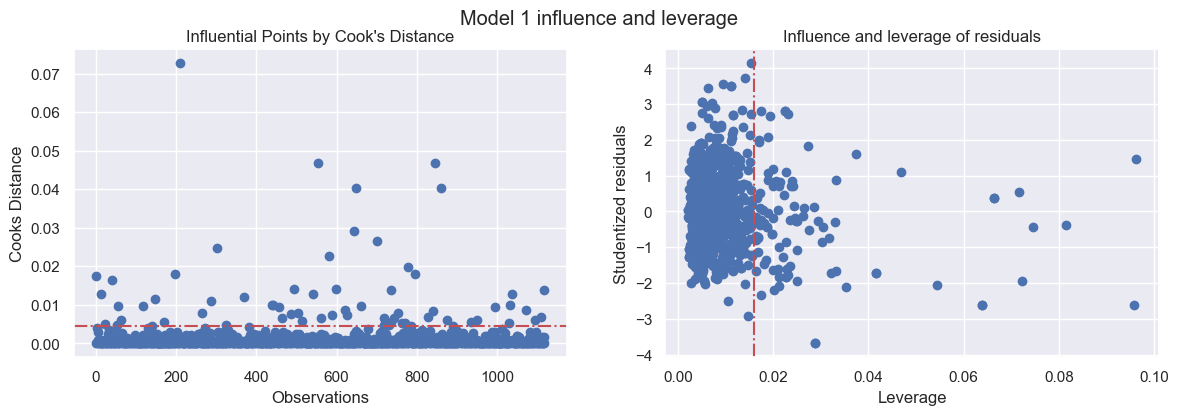

In [29]:
plot_influence(ols, "Model 1 influence and leverage")

The red lines in each graph correspond to the 3-standard-deviations-above-the-median cutoff that we did for these two outlier metrics, so have more than a few. Let's consolidate the indices for these observations into a single index series.

In [30]:
# Create index for all indices in either outlier set
elements = (
    set(cooks_outliers.index)
    | set(high_leverage_outliers.index)
    | set(sr_outliers.index)
)
full_idx = pd.Index(elements)
full_idx = full_idx.sort_values()

# Make a df of all outlier sets
combined_outliers = outliers_df.iloc[outliers_df.index.isin(full_idx)]

print(
    f"Cooks distance: {len(cooks_outliers)} observations\nLeverage: {len(high_leverage_outliers)}\nStudentized residuals: {len(sr_outliers)} observations\nTotal outliers: {len(combined_outliers)}"
)

Cooks distance: 18 observations
Leverage: 19
Studentized residuals: 10 observations
Total outliers: 36


## <a id='toc3_8_'></a>[Model Improvements](#toc0_)
We have a slight overlap between the three sets, bringing us to a total of 29 high-influence outliers. In this next section, we'll explore two options to see which yields more improvements to our model: 

1. Drop the outliers corresponding to both the cooks outliers and high leverage observations
2. Set the outliers to either Q1 or Q3 for whichever dimensions they are considered outliers for at the feature level

### <a id='toc3_8_1_'></a>[Option 1](#toc0_)

In [31]:
# Drop outliers from our training set
x_train_dropped_outliers = model_1.x_train.drop(index=full_idx)
y_train_dropped_outliers = Y.iloc[x_train_dropped_outliers.index]

# Rerun OLS
option1_ols = run_OLS(x_train_dropped_outliers, y_train_dropped_outliers)
option1_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     342.5
Date:                Mon, 06 May 2024   Prob (F-statistic):          3.70e-308
Time:                        08:11:59   Log-Likelihood:                -836.85
No. Observations:                1083   AIC:                             1694.
Df Residuals:                    1073   BIC:                             1744.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.4140      0.016    645.899      0.000      10.382      10.446
fixed_acidity            0.8430      0.038     22.378      0.000       0.769       0.917
volatile_acidity         0.0837      0.022      3.814      0.000       0.041       0.127
citric_acid              0.1191      0.028      4.193      0.000       0.063       0.175
residual_sugar           0.4423      0.024     18.413      0.000       0.395       0.489
total_sulfur_dioxide    -0.0792      0.018     -4.325      0.000      -0.115      -0.043
density                 -1.1064      0.028    -39.398      0.000      -1.161      -1.051
pH                       0.5368      0.024     22.045      0.000       0.489       0.585
sulphates                0.1366      0.021      6.595      0.000       0.096       0.177
quality                  0.2045      0.019     10.619      0.000       0.167       0.242
==============================================================================
Omnibus:                       15.962   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.264
Skew:                           0.287   Prob(JB):                     0.000294
Kurtosis:                       3.175   Cond. No.                         4.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# Create dictionary to isolate key values for the model
temp = {
    "R-squared": option1_ols.rsquared,
    "R-squared adjusted": option1_ols.rsquared_adj,
    "F-statistic": option1_ols.fvalue,
    "F-stat p-value": option1_ols.f_pvalue,
}
# print as dataframe
pd.DataFrame.from_dict(temp, orient="index", columns=["Values"]).round(3)

,Values
R-squared,0.742
R-squared adjusted,0.740
F-statistic,342.497
F-stat p-value,0.000


This model has a fairly high R-squared value, and still performs well once we've adjusted for the number of the predictors in the $R^2$ adjusted statistic. Our F-statistic is really high, and the corresponding p-value is vanishingly small, so we can conclude both that the model is statistically significant across our feature set and that they are significant predictors of our dependent variable. Let's take a look now at model performance. 

## <a id='toc3_9_'></a>[Option 1 model performance](#toc0_)

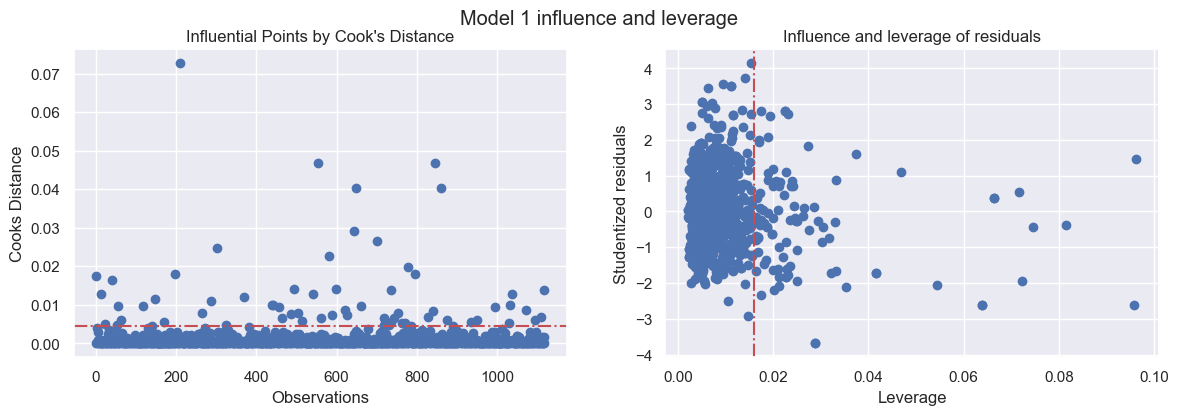

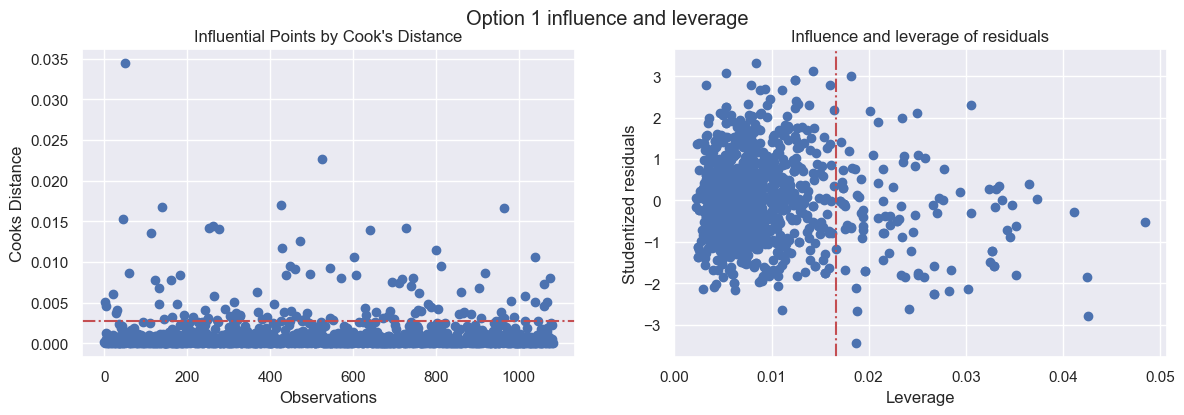

In [33]:
plot_influence(ols, "Model 1 influence and leverage")
plot_influence(option1_ols, "Option 1 influence and leverage")

$R^2$ has gone up in this new model, with our cook's D and studentized residuals getting much tighter. Let's create a regression for option 2, where we just set the floor for each feature as the 25th percentile of that feature, with the ceiling for each feature being the 75th percentile of that feature.

### <a id='toc3_9_1_'></a>[Option 2](#toc0_)

In [34]:
# Copy model_data's X matrix
df = model_1.x_train.copy()

# Calculate percentiles for each feature, resetting values that are outliers
for variable in df.columns[1:]:

    # change instance to 25 percentile if lower, and 75 percentile if lower
    df[variable] = df[variable].apply(
        lambda x: (
            np.percentile(wine_df[variable], 25)
            if x < np.percentile(wine_df[variable], 25)
            else x
        )
    )
    df[variable] = df[variable].apply(
        lambda x: (
            np.percentile(wine_df[variable], 75)
            if x > np.percentile(wine_df[variable], 75)
            else x
        )
    )

# Rerun OLS
option2_ols = run_OLS(df, pd.DataFrame(model_1.y_train))
option2_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     16.01
Date:                Mon, 06 May 2024   Prob (F-statistic):           1.01e-17
Time:                        08:12:01   Log-Likelihood:                -1598.9
No. Observations:                1119   AIC:                             3212.
Df Residuals:                    1112   BIC:                             3247.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3608      0.079      4.569      0.000       0.206       0.516
fixed_acidity            2.5619      0.561      4.569      0.000       1.462       3.662
volatile_acidity        -0.6972      0.305     -2.285      0.023      -1.296      -0.099
citric_acid              1.2292      0.225      5.460      0.000       0.787       1.671
residual_sugar           0.1495      0.250      0.599      0.549      -0.340       0.639
total_sulfur_dioxide     7.9384      1.738      4.569      0.000       4.529      11.348
density               -235.6137     42.766     -5.509      0.000    -319.524    -151.703
pH                      13.0840      3.777      3.464      0.001       5.674      20.494
sulphates                0.9904      0.457      2.167      0.030       0.094       1.887
quality                  1.8042      0.395      4.569      0.000       1.029       2.579
==============================================================================
Omnibus:                      100.763   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.718
Skew:                           0.811   Prob(JB):                     3.04e-28
Kurtosis:                       3.300   Cond. No.                     2.02e+46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.59e-87. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The $R^2$ for this model is really low, and truncating the variance of the features with outliers created other problems in our data. We have a multicolinearity problem since there are multiple acidity features in the model, and some of the features are no longer statistically significant now that we've truncated the values. This doesn't appear to be a good option for model refinement because it also fundamentally changes the relationships between our predictors, much more than simply deleting the most extreme 30 or so odd observations from the training set.

We should adopt option 1, which only dropped our 36 of our 424 total outliers within the training set. This is a very small loss in the scheme of our 1600 datapoints, and also serves to strengthen our model's predictive power. For the next iteration of the model, we'll use weighted least squares regression on the option data to refine the Least Squares model even further. 

# <a id='toc4_'></a>[Weighted Least Squares](#toc0_)

## <a id='toc4_1_'></a>[WLS model creation](#toc0_)

Let's begin by preparing our dataframes for modeling 

In [35]:
# Create X and Y from the weights_df
Y = wine_df[["alcohol"]]
X = wine_df.drop(columns=["alcohol"])

# Scale the data
scaler = StandardScaler()
model = scaler.fit(X)
X = pd.DataFrame(model.transform(X), columns=X.columns)

# Split data into training and test sets
X_train, X_test, y_train, y_test = dataset_splitter(X, Y)
y_train = y_train.values.reshape(-1, 1)
X_train = sm.add_constant(X_train)

Now that we've set up our scaled dataframes, let's set up this model iteration.

In [36]:
# Set weights
length = len(x_train_dropped_outliers)
w = np.ones(length)
w[length * 6 // 10 :] = 3

# Fit WLS model
model = WLS(y_train_dropped_outliers, x_train_dropped_outliers, weights=1 / (w**2))
wls = model.fit()
wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.737
Model:                            WLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     334.0
Date:                Mon, 06 May 2024   Prob (F-statistic):          7.33e-304
Time:                        08:12:01   Log-Likelihood:                -1070.8
No. Observations:                1083   AIC:                             2162.
Df Residuals:                    1073   BIC:                             2211.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.4024      0.016    646.268      0.000      10.371      10.434
fixed_acidity            0.8003      0.037     21.363      0.000       0.727       0.874
volatile_acidity         0.1185      0.022      5.474      0.000       0.076       0.161
citric_acid              0.1260      0.028      4.502      0.000       0.071       0.181
residual_sugar           0.4001      0.024     16.669      0.000       0.353       0.447
total_sulfur_dioxide    -0.0863      0.018     -4.849      0.000      -0.121      -0.051
density                 -1.0584      0.028    -37.729      0.000      -1.113      -1.003
pH                       0.5063      0.024     21.248      0.000       0.460       0.553
sulphates                0.1301      0.021      6.243      0.000       0.089       0.171
quality                  0.2594      0.020     13.212      0.000       0.221       0.298
==============================================================================
Omnibus:                       55.869   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.836
Skew:                           0.317   Prob(JB):                     9.50e-27
Kurtosis:                       4.501   Cond. No.                         5.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model is the best version of our model with alcohol regressed on all significant features in our dataset. Let's move to model validation before judging it against our test set.

## <a id='toc4_2_'></a>[WLS validation](#toc0_)

In [37]:
compare_regressions(option1_ols, wls)

,current model,new model
R-squared-adj,7.400000e-01,7.350000e-01
F-probabilities,3.696541e-308,7.327465e-304
F-statistic,3.424975e+02,3.340409e+02


Here we can see that the new model, our weighted least squares regression outperforms our option_1 model with a $R^2$ adjusted value of 0.743. Also, it improves on our already strong F-statistic and F-statistic probabilities, so we know that these features are statistically significant predictors of alcohol by volume in wine production. Now let's test this model using our test dataset to see how it performs. 

### <a id='toc4_2_1_'></a>[WLS model testing](#toc0_)

In [38]:
# Ensure that the order of columns in x_test is the same as the model parameters
features = wls.params.index
X_test = sm.add_constant(X_test)
X_test = X_test[features]

# Calculate predicted y values from the test set
y_test_pred = wls.predict(X_test)

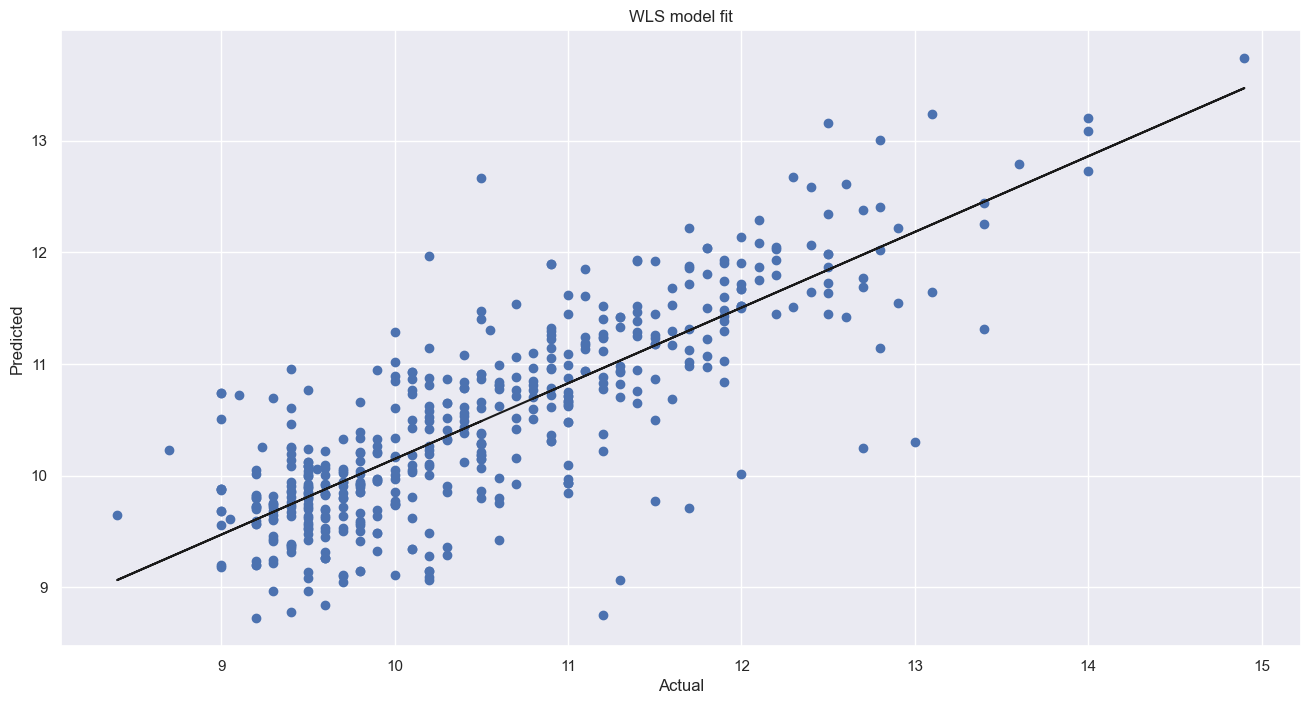

test_data R-squared: 0.665
WLS R-squared: 0.737


In [39]:
# Plot model predictions against actual test_data
plt.scatter(y_test, y_test_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("WLS model fit")

# PLot the line of best fit also
z = np.polyfit(
    y_test.values.reshape(
        480,
    ),
    y_test_pred,
    1,
)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "k")
plt.show()

# Let's calculate R-squared for the test-set and compare it to our wls model
r_squared = (
    sm.OLS(y_test.values.reshape(480, 1), sm.add_constant(y_test_pred)).fit().rsquared
)
print("test_data R-squared:", np.round(r_squared, 3))
print("WLS R-squared:", np.round(wls.rsquared, 3))

From the scatterplot above, we can see that our model performs fairly well at predicting alcohol content. If we compare the r-squared value from the training set with that for the test data regressed on the training data for alcohol, we can see these numbers are fairly close, but there is a slight drop in R-squared when we run the test data so we have some overfiting here. Our analysis found that leaving in our 240 duplicate rows accounts accounts for this extra noise. We could potentially consider dropping those rows to refine the fit here, but let's move on to conducting logistic regression for quality. 

## <a id='toc4_3_'></a>[Logistic Regression](#toc0_)

First, let's define our categories for high-quality wine and standard wine. For our classification purposes, wine with quality ratings above 6 are considered high-quality, and wines with ratings 3-5 will be considered standard wines. This is based off the domain for wines in our dataset being 3-8 inclusive, and also off the assumption that wines 0-2 are poor quality, and have not been included in our dataset.

In [40]:
# Create quality rating dummy variable based on quality
wine_df["quality_rating"] = np.where(wine_df["quality"] >= 6, 1, 0)

# Copy wine_df
df = wine_df.copy()

# Create training and test data from this scaled dataframe
X = sm.add_constant(df.drop(columns=["quality_rating"]))
# X = df.drop(columns=["quality_rating"])
Y = df[["quality_rating"]]
X = scale_dataframe(X)
x_train, x_test, y_train, y_test = dataset_splitter(X, Y)

We should now check the balance between the quality ratings that we created.


In [41]:
# Tally quality and breakdown of high-quality category
n_high_quality = y_train.quality_rating.value_counts()
# training_set_breakdown = x_train.quality_rating[x_train.quality_rating == 1].value_counts()

print(n_high_quality)
# print(training_set_breakdown)

quality_rating
1    568
0    551
Name: count, dtype: int64


Our first printout shows that our proportions of high-quality to standard quality wines are slightly imbalanced. The second printout shows that our high-quality wines are heavily weighted toward 6's, with almost no observations of 8's. So we're going to randomly sample wines from the 6 category to drop from our dataset, so that we have a more balanced distribution of wines to work with across the high and standard quality wines.

In [42]:
# Determine the gap in observations between two quality ratings
gap = n_high_quality.values[0] - n_high_quality.values[1]

# Isolate the wines with quality of 6, and create randomized indices
sixes = df[df.quality == 6]
random_indices = [randint(0, len(sixes)) for x in range(0, 17)]

# Drop those observations from both x and y training sets
x_train.drop(x_train.index[random_indices], inplace=True, errors="ignore")
y_train.drop(y_train.index[random_indices], inplace=True, errors="ignore")


# Drop quality from x_train and x_test
x_train.drop(columns=["quality"], inplace=True)
x_test.drop(columns=["quality"], inplace=True)

Now that we've done the initial prep, let's get to modeling. Let's set a baseline by running a logistic regression on all features in our set, and testing the model across for accuracy, precision, and recall. 


In [43]:
# Fit model
logR = LogisticRegression(max_iter=30000)
logR.fit(x_train, y_train)

# Create confusion matrix
predictions = logR.predict(x_test)
print(confusion_matrix(y_test, predictions))

[[146  47]
 [ 87 200]]


The confusion matrix above shows our positives and negatives according to this model formulation. Let's calculate relevant performance metrics from the datapoints here to take a closer look before get to tuning the model further. 


<br><br>
- Accuracy shows the overall correctness of the model's predictions<br> $$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)} $$<br><br>
- Precision: Precision measures the model's ability to correctly predict the positive class<br> $$Precision = \frac{TP}{(TP + FP)} $$<br><br>
- Recall (Sensitivity/True Positive Rate) quantifies the model's ability to correctly identify the positive class instances<br> $$Recall = \frac{TP}{(TP + FN)}$$<br><br>
- F1 Score: The F1 score combines precision and recall into a single metric. It is the harmonic mean of precision and recall and provides a balanced measure<br> $$F1\:score =2 * \frac{(Precision * Recall)}{(Precision + Recall)}$$


In [44]:
#Calculate performance metrics for training set
y_pred = logR.predict(x_train)


accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

metrics = ["accuracy", "precision", "recall", "F1_score"]
values = [accuracy, precision, recall, f1]

model_performance = pd.DataFrame(data=metrics, columns=["metrics"])
model_performance[str(logR.n_features_in_)] = values

model_performance.style.format(precision=4)

,metrics,12
0,accuracy,0.7545
1,precision,0.7662
2,recall,0.7401
3,F1_score,0.7530


For this next part, we'll use Recursive Feature Elimination (RFE) to work toward a more optimal model, similar to how we used backward elimination to create our working feature set in the linear regressions above. RFE starts with all features in the training set, and successively removes all features until the desired number remains. <br><br>This algorithm keeps the strongest k features for a given model specification k, so we'll iteratively run regressions for decreasing numbers of features, appending the model_performance dataframe to show our performance metrics for each iteration. 


In [45]:
k_range = list(range(10, 0, -1))

counter = 11
while counter > 0:
    stats = RFE_performance_training(x_train, y_train, counter)
    model_performance[str(counter)] = stats
    counter -= 1

model_performance.style.format(precision=4)

,metrics,12,11,10,9,8,7,6,5,4,3,2,1
0,accuracy,0.7545,0.7545,0.7545,0.7545,0.7518,0.7509,0.7545,0.7482,0.7491,0.7409,0.7500,0.7083
1,precision,0.7662,0.7662,0.7662,0.7662,0.7630,0.7616,0.7672,0.7602,0.7616,0.7556,0.7733,0.7323
2,recall,0.7401,0.7401,0.7401,0.7401,0.7384,0.7384,0.7384,0.7330,0.7330,0.7204,0.7151,0.6667
3,F1_score,0.7530,0.7530,0.7530,0.7530,0.7505,0.7498,0.7525,0.7464,0.7470,0.7376,0.7430,0.6979


Now that we have our model performance across each model specification of k features, let's isolate the strongest model based on F1_score since it considers both precision and recall.

In [46]:
# Transpose model_performance and adjust columns
model_performance = model_performance.T
model_performance.columns = model_performance.iloc[0, :]
model_performance = model_performance.iloc[1:, :]
model_performance

metrics,accuracy,precision,recall,F1_score
12,0.754529,0.766234,0.740143,0.752963
11,0.754529,0.766234,0.740143,0.752963
10,0.754529,0.766234,0.740143,0.752963
9,0.754529,0.766234,0.740143,0.752963
8,0.751812,0.762963,0.738351,0.750455
7,0.750906,0.761553,0.738351,0.749773
6,0.754529,0.767225,0.738351,0.752511
5,0.748188,0.760223,0.732975,0.74635
4,0.749094,0.761639,0.732975,0.747032
3,0.740942,0.755639,0.72043,0.737615


Now let's rerun RFE to create our regression model based on the model specification in df with the highest F1_score.

In [53]:
model = LogisticRegression()

# Use RFE to select the top k features
rfe = RFE(model, n_features_to_select=int(model_performance.F1_score.idxmax()))
rfe.fit(x_train, y_train)

# Assemble dataset of features into df
final_model = pd.DataFrame(
    {"features": rfe.feature_names_in_, "selection": rfe.support_}
)
# Filter down to just included variables
final_model = final_model[final_model.selection == True]

# Add coefficients
final_model["model_coefficients"] = rfe.estimator_.coef_[0]

# Drop selection column
final_model.drop(columns="selection", inplace=True)

# Show final model
final_model.style.format(precision=3)

,features,model_coefficients
0,const,0.000
1,fixed_acidity,-0.012
2,volatile_acidity,-0.627
3,citric_acid,-0.193
4,residual_sugar,-0.066
5,chlorides,-0.147
6,free_sulfur_dioxide,0.179
7,total_sulfur_dioxide,-0.474
8,density,0.197
9,pH,-0.161


Now that we have this model, let's run it against the test set to check for overfitting. 

In [48]:
# Make df of training and test data for x_train, x_test
test_set_stats = RFE_performance(x_train, y_train, x_test, y_test, 7)


pd.DataFrame({"metric": model_performance.columns,"training_set_value":RFE_performance_training(x_train,y_train,7), "test_set_value": test_set_stats})

,metric,training_set_value,test_set_value
0,accuracy,0.750906,0.712500
1,precision,0.761553,0.804082
2,recall,0.738351,0.686411
3,F1_score,0.749773,0.740602


We can see that the model performs equally well on the test data that we partitioned earlier for testing, so we don't have to worry about overfitting here.
Now that we've tested this model, let's conclude with model interpretations and ideas for further research. 

# <a id='toc5_'></a>[Model interpretations](#toc0_)
## <a id='toc5_1_'></a>[Weighted Least Squares](#toc0_)

Let's print our wls model features with associated coefficients before we discuss interpretations

In [49]:
wls_model = pd.DataFrame(data=wls.params, columns=["wls_coefficients"]).reset_index()
wls_model.columns = ["features", "wls_coefficients"]
wls_model

,features,wls_coefficients
0,const,10.402385
1,fixed_acidity,0.800323
2,volatile_acidity,0.118470
3,citric_acid,0.126004
4,residual_sugar,0.400106
5,total_sulfur_dioxide,-0.086338
6,density,-1.058417
7,pH,0.506302
8,sulphates,0.130109
9,quality,0.259356


For each variable here, the effect on alcohol is predicted to increase ABV by the value of the coefficient, assuming that all other values are held constant.

## <a id='toc5_2_'></a>[Logistic Regression](#toc0_)

In [50]:
# Calculate increases in odds for each variable
final_model["odds_increase"] = final_model.model_coefficients.apply(lambda x: np.exp(x))
final_model.style.format(precision=3)

,features,model_coefficients,odds_increase
0,const,0.000,1.000
1,fixed_acidity,-0.012,0.988
2,volatile_acidity,-0.627,0.534
3,citric_acid,-0.193,0.825
4,residual_sugar,-0.066,0.937
5,chlorides,-0.147,0.864
6,free_sulfur_dioxide,0.179,1.196
7,total_sulfur_dioxide,-0.474,0.622
8,density,0.197,1.218
9,pH,-0.161,0.851


For each variable here, the model coefficient represents the impact to log-odds of quality_rating. The third colummn thus calculate the impact of the odds of a wine being high quality for a unit increase in that variable, assuming that all other variables are held constant.


# <a id='toc6_'></a>[Conclusions](#toc0_)
So what are the takeaways for red wine producers? Higher alcohol content is a strong marker of quality. According to our model, they are 170% more likely to say that a high ABV wine is good quality, with other markers being less strong indicators. <br><br> But what features are more likely to produce a higher alcohol wine?  Higher fixed acidity, higher pH, and higher residual sugar all contribute to a more alcoholic wine, whereas higher density and higher total_sulfur_dioxide detract from a higher alcohol content. 

# <a id='toc7_'></a>[Ideas for further research](#toc0_)
To strengthen this analysis, we should:
- Verify the meaning of the duplicates we found in the data
- Control for varieties of grapes used in the wine production
- Limit our dataset to wines of similar ages
- Define the lower and upper limits possible for the variables to get a better view of the limits of our model's predictive power. 
- Explore principal component analysis or other techniques to refine the models and counteract some of the limitations of the present data 

With these measures in place, we'll be able to more confidently model and predict both alcohol content and quality for red wines of this type. 